In [ ]:
using Plots
using LinearAlgebra
using DifferentialEquations
using Random

In [ ]:
include("DTM.jl")
include("lorentz_system.jl")
include("RK4.jl")

In [ ]:
function Correlation(vec1,vec2)
    return sum(vec1.*vec2)/norm(vec1)/norm(vec2)
end

In [ ]:
'
function Path(ẋ::Function, tsteps, x̄₀, p)
    x̄=x̄₀
    Δt = tsteps[1]
    X = zeros(3,length(tsteps))
    for i=1:length(tsteps)-1
        X[:,i] = x̄
        x̄= ẋ(p,x̄,Δt)
        Δt = tsteps[i+1]-tsteps[i]
        println(Δt)
    end
    return X
end
'

In [ ]:
# Finds path for starting position x̄₀
function Path(ẋ::Function, Δt, tim, x̄₀, p)
    tsteps = Int(tim/Δt)
    x̄=x̄₀
    X = zeros(3,tsteps)
    for i=1:tsteps
        x̄= ẋ(p,x̄,Δt)
        X[:,i] = x̄
    end
    return X
end

In [ ]:
function Plot_Correlation(Δt,time,inital_vals,p)
    
    plt=plot()
    for x̄₀ in eachcol(inital_vals)
        X = Path(DTM, Δt, time, x̄₀, p)

        tsteps = Int(time/Δt)
        x̄=x̄₀
        XA5 = zeros(3,tsteps)
        for i=1:tsteps
            prob = ODEProblem(LorentzSystem,x̄₀,(0.0,Δt*i),[θ,μ,β])
            sol = solve(prob, RadauIIA5())
            x̄= sol[end]
            XA5[:,i] = x̄
        end

        correlation = zeros(tsteps)
        for i=1:tsteps
            correlation[i] = Correlation(XA5[:,i],X[:,i])
        end

        plot!(plt,range(0,stop=time-Δt,step=Δt),correlation,label="x₀ = $x̄₀")
    end
    display(plt)

end

In [ ]:
function Plot_Correlation_Histogram(Δt,time,inital_vals,p)
    
    #plt=plot()
    correlations=zeros(length(inital_vals[1,:]))
    j=1
    for x̄₀ in eachcol(inital_vals)
        X = Path(DTM, Δt, time, x̄₀, p)

        tsteps = Int(time/Δt)
        x̄=x̄₀
        XA5 = zeros(3,tsteps)
        for i=1:tsteps
            prob = ODEProblem(LorentzSystem,x̄₀,(0.0,Δt*i),[θ,μ,β])
            sol = solve(prob, RadauIIA5())
            x̄= sol[end]
            XA5[:,i] = x̄
        end

        correlation = 1
        i=1
        while correlation > 0.5
            correlation = Correlation(XA5[:,i],X[:,i])
            i+=1
        end
        correlations[j] = i*Δt
        j=j+1
    end
    plot(initial_vals[3,:],correlations, seriestype= :bar, ylabel= "time", xlabel= "initial z value", legend=false)

end

In [226]:
function Plot_Correlation_Heatmap(Δt,time,inital_vals,p)
    
    #plt=plot()
    tsteps = Int(time/Δt)
    correlations=zeros(length(inital_vals[1,:]),tsteps)
    j=1
    for x̄₀ in eachcol(inital_vals)
        X = Path(DTM, Δt, time, x̄₀, p)
        x̄=x̄₀
        XA5 = zeros(3,tsteps)
        for i=1:tsteps
            prob = ODEProblem(LorentzSystem,x̄₀,(0.0,Δt*i),[θ,μ,β])
            sol = solve(prob, RadauIIA5())
            x̄= sol[end]
            XA5[:,i] = x̄
        end

        for i=1:tsteps
            correlations[j,i] = Correlation(XA5[:,i],X[:,i])
        end
    end

    return correlations
end

Plot_Correlation_Heatmap (generic function with 1 method)

In [281]:
## parameter values
θ = 10.0; β = 8/3; μ = 28.0
p=[θ,μ,β]
time = 3
Δt = 0.01
# initial values
x̄₀ = [10;
      17;
      33]

nr=50
initial_vals = zeros(3,nr)
for i=1:nr
    initial_vals[:,i] = [10;
                         17;
                         32+i*0.1]
end

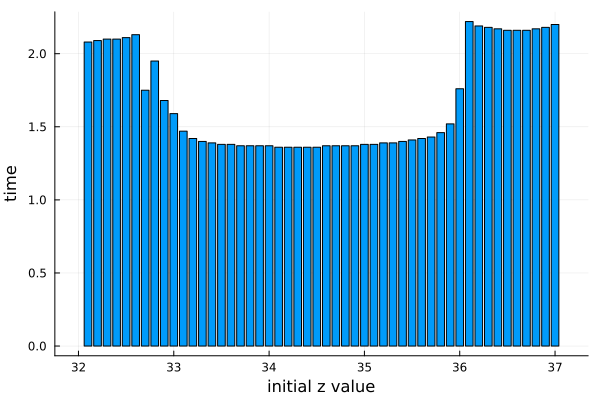

In [282]:
Plot_Correlation_Histogram(Δt,time,initial_vals,p) # prova göra en yta :)))))

In [267]:
correlations=Plot_Correlation_Heatmap(Δt,time,initial_vals,p)

1×300 Matrix{Float64}:
 1.0  0.999999  0.999999  0.999999  0.999999  …  0.777351  0.777335  0.778597

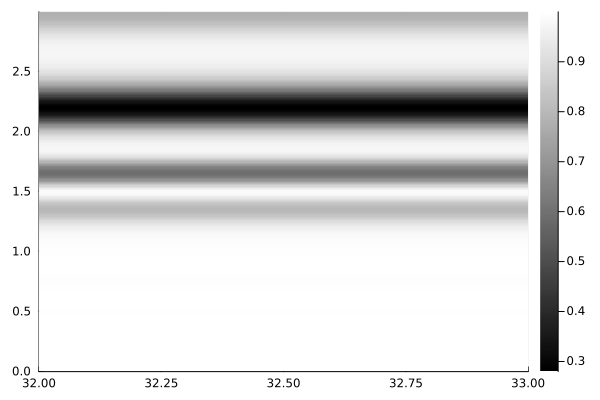

In [271]:
plot(initial_vals[3,:],range(0,stop=time-Δt,step=Δt),correlations, seriestype= :heatmap,c=[:black,:white])

In [277]:
histogram2d(correlations)

InexactError: InexactError: trunc(Int64, NaN)

In [230]:
print(size(correlations))
print(range(0,stop=time-Δt,step=Δt))

(5, 300)0.0:0.01:2.99

In [ ]:
gr()
heatmap(1:3,1:3,[1 1.5 1.6; 1 2 ; 1 1.1 1.2])

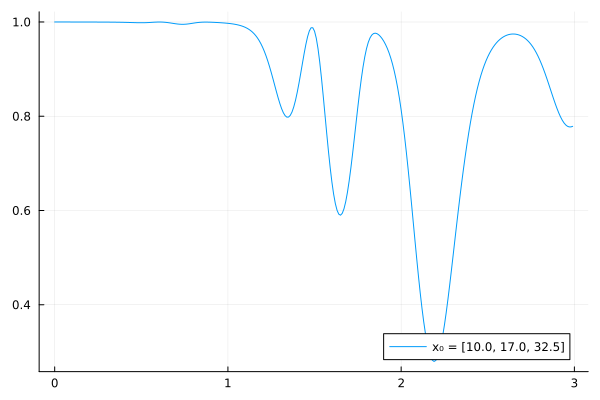

In [278]:
Plot_Correlation(Δt,time,initial_vals,p)

In [239]:
prob = ODEProblem(LorentzSystem,x̄₀,(0.0,time),[θ,μ,β])
sol = solve(prob, RadauIIA5())

retcode: Success
Interpolation: 3rd order Hermite
t: 63-element Vector{Float64}:
 0.0
 0.04085729164131705
 0.08550535783960733
 0.12599526578931786
 0.16648517373902838
 0.20920352159053485
 0.2430229020554862
 0.2680444577165736
 0.30436455809385443
 0.34769831338948404
 ⋮
 2.5353329464876606
 2.5853885481150254
 2.6393980333680602
 2.7086875107768247
 2.777976988185589
 2.860715581478129
 2.9237476722663494
 2.974684405480306
 3.0
u: 63-element Vector{Vector{Float64}}:
 [10.0, 17.0, 33.0]
 [11.743699714202718, 13.356556583216602, 36.12622163718156]
 [11.327692300086882, 8.167691015532561, 37.368366072490446]
 [9.523453145057058, 4.154500492439753, 35.984483385729845]
 [7.263349266393124, 1.7526553625945764, 33.217269952286856]
 [5.123287556227101, 0.7396551667886408, 29.92871321853074]
 [3.835793250524892, 0.6082872826397813, 27.439848611858128]
 [3.1312080878736372, 0.7133369946752136, 25.723131186960867]
 [2.44132665976881, 1.0220719085176868, 23.4297836033668]
 [2.032766215959730

In [242]:
tsteps = Int(time/Δt)
x̄=x̄₀
XA5 = zeros(3,tsteps)
for i=1:tsteps
    prob = ODEProblem(LorentzSystem,x̄₀,(0.0,Δt*i),[θ,μ,β])
    sol = solve(prob, RadauIIA5())
    x̄= sol[end]
    XA5[:,i] = x̄
end

In [243]:
X = Path(DTM, Δt, time, x̄₀, [θ, μ, β])

3×300 Matrix{Float64}:
 10.6095  11.0852  11.4299  11.6471  …  -5.28235   -5.75246   -6.26159
 16.2561  15.4024  14.447   13.405      -9.73259  -10.582    -11.4859
 33.8263  34.6273  35.3645  36.0043     10.7882    11.0714    11.4505

In [244]:
correlation = zeros(tsteps)
for i=1:tsteps
    correlation[i] = Correlation(XA5[:,i],X[:,i])
end

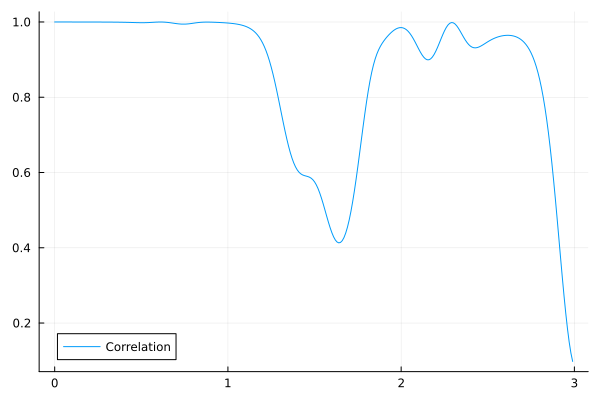

In [245]:
plot(range(0,stop=time-Δt,step=Δt),correlation, label="Correlation")

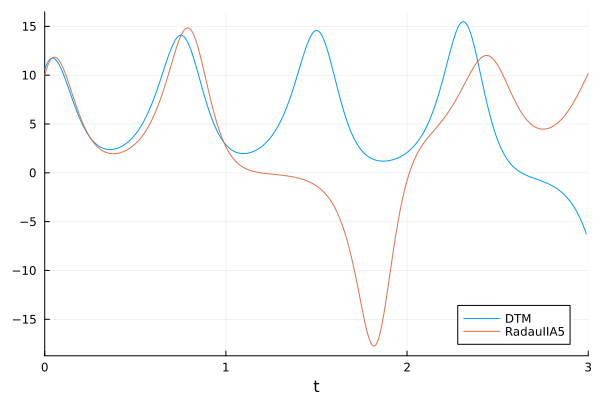

In [246]:
plot(range(0,stop=time-Δt,step=Δt), X[1,:], label="DTM")
plot!(sol, idxs=(1), label="RadauIIA5")